In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import os

Minimizando a Resolução da imagem e deginindo o tamanho do Lote

In [2]:
base_dir = "./training"

# IMAGE_WIDTH  = 720
# IMAGE_HEIGHT = 1280
IMAGE_WIDTH  = 256
IMAGE_HEIGHT = 256
BATCH_SIZE = 32

Definindo diretório para checkpoints

In [3]:
checkpoint_path = "checkpoints/cp.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)

cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_weights_only=True,
                                                 verbose=1)


Criando um gerador de dados que irá redimensionar as imagens e usa 20% dos dados para validação.

In [4]:
data_generator = tf.keras.preprocessing.image.ImageDataGenerator(
  rescale=1. / 255,
  validation_split=0.2)

Criando gerador para dados de treinamento

In [5]:
train_generator = data_generator.flow_from_directory(
  base_dir,
  target_size=(IMAGE_HEIGHT, IMAGE_WIDTH),
  batch_size=BATCH_SIZE,
  subset='training')

Found 22438 images belonging to 50 classes.


E gerador para validação

In [6]:
val_generator = data_generator.flow_from_directory(
  base_dir,
  target_size=(IMAGE_HEIGHT, IMAGE_WIDTH),
  batch_size=BATCH_SIZE,
  subset='validation')

Found 5587 images belonging to 50 classes.


Triggering `train_generator` para cada batch

In [7]:
for image_batch, label_batch in train_generator:
  break

Mostrando os labels de classificação

In [8]:
print(train_generator.class_indices)

{'1': 0, '10': 1, '11': 2, '12': 3, '13': 4, '14': 5, '15': 6, '16': 7, '17': 8, '18': 9, '19': 10, '2': 11, '20': 12, '21': 13, '22': 14, '23': 15, '24': 16, '25': 17, '26': 18, '27': 19, '28': 20, '29': 21, '3': 22, '30': 23, '31': 24, '32': 25, '33': 26, '34': 27, '35': 28, '37': 29, '38': 30, '39': 31, '4': 32, '40': 33, '41': 34, '42': 35, '43': 36, '44': 37, '45': 38, '46': 39, '47': 40, '48': 41, '49': 42, '5': 43, '50': 44, '51': 45, '6': 46, '7': 47, '8': 48, '9': 49}


Definindo a dimensão das imagens para acomodar imagens RGB (com 3 canais)

In [9]:
IMG_SHAPE = (IMAGE_HEIGHT, IMAGE_WIDTH, 3)

Criando uma model com base na CNN pré treinada MobileNet V2, desenvolvida pela Google e pré-treinada usando o dataset da ImageNet, sem a camada superior, que inclui as camadas de classificação.

In [10]:
base_model = tf.keras.applications.densenet.DenseNet201(
    include_top=False,
    weights='imagenet',
    input_shape=IMG_SHAPE
)


2023-09-24 13:15:27.748052: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M1
2023-09-24 13:15:27.748076: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 16.00 GB
2023-09-24 13:15:27.748084: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 5.33 GB
2023-09-24 13:15:27.748145: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:303] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-09-24 13:15:27.748344: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:269] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Aplicando fine-tunning nas últimas camadas do modelo, forçando os pesos a se ajustarem äs características mais específicas do dataset.

In [11]:
base_model.trainable = True

Mostrando a quantidade de camadas no modelo.

In [12]:
print("Number of layers in the base model: ", len(base_model.layers))

Number of layers in the base model:  707


Definindo a camada a partir da qual será aplicado o fine-tuning.

In [13]:
fine_tune_at = 150

Congelando as camadas antes da camada definida em `fine_tune_at`

In [14]:
for layer in base_model.layers[:fine_tune_at]:
  layer.trainable = False

Montando o modelo da CNN:
1. Modelo pré-treinado da MobileNet V2 com fine-tunning a partir da 100a camada;
2. Camada de Convolução com 32 filtros e ativação Relu;
3. Camada de Dropout de 20% dos nós;
4. Camada de Pooling;
5. Camada FC com 17 labels de classificação

In [15]:
model = tf.keras.Sequential([
    base_model,  # 1
    tf.keras.layers.Conv2D(32, 3, activation='relu'),  # 2
    tf.keras.layers.Dropout(0.4),  # 3
    tf.keras.layers.GlobalAveragePooling2D(),  # 4
    tf.keras.layers.Dense(50, activation='softmax')  # 5
])

Compilando a model

In [16]:
model.compile(optimizer=tf.keras.optimizers.experimental.SGD(learning_rate=0.001),  # 1
              loss='categorical_crossentropy',  # 2
              metrics=['accuracy'])  # 3
# To see the model summary in a tabular structure
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 densenet201 (Functional)    (None, 8, 8, 1920)        18321984  
                                                                 
 conv2d (Conv2D)             (None, 6, 6, 32)          552992    
                                                                 
 dropout (Dropout)           (None, 6, 6, 32)          0         
                                                                 
 global_average_pooling2d (  (None, 32)                0         
 GlobalAveragePooling2D)                                         
                                                                 
 dense (Dense)               (None, 50)                1650      
                                                                 
Total params: 18876626 (72.01 MB)
Trainable params: 17146962 (65.41 MB)
Non-trainable params: 1729664 (6.60 MB)
__________

Definindo as épocas para o treinamento da model

In [17]:
epochs = 10

Treinando a model

In [18]:
history = model.fit(train_generator,
                    epochs=epochs,
                    validation_data=val_generator,
                    callbacks=[cp_callback])

Epoch 1/10


2023-09-24 13:15:35.269813: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


702/702 [==============================] - ETA: 0s - loss: 2.1760 - accuracy: 0.5182

2023-09-24 13:44:16.600786: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.



Epoch 1: saving model to checkpoints/cp.ckpt
702/702 [==============================] - 1984s 3s/step - loss: 2.1760 - accuracy: 0.5182 - val_loss: 3.2329 - val_accuracy: 0.3039
Epoch 2/10
702/702 [==============================] - ETA: 0s - loss: 0.5130 - accuracy: 0.9118
Epoch 2: saving model to checkpoints/cp.ckpt
702/702 [==============================] - 2334s 3s/step - loss: 0.5130 - accuracy: 0.9118 - val_loss: 3.0576 - val_accuracy: 0.4364
Epoch 3/10
702/702 [==============================] - ETA: 0s - loss: 0.1736 - accuracy: 0.9678
Epoch 3: saving model to checkpoints/cp.ckpt
702/702 [==============================] - 2450s 3s/step - loss: 0.1736 - accuracy: 0.9678 - val_loss: 3.1594 - val_accuracy: 0.4731
Epoch 4/10
702/702 [==============================] - ETA: 0s - loss: 0.0987 - accuracy: 0.9754
Epoch 4: saving model to checkpoints/cp.ckpt
702/702 [==============================] - 2395s 3s/step - loss: 0.0987 - accuracy: 0.9754 - val_loss: 3.2327 - val_accuracy: 0.4906

Visualizando as curvas de aprendizado

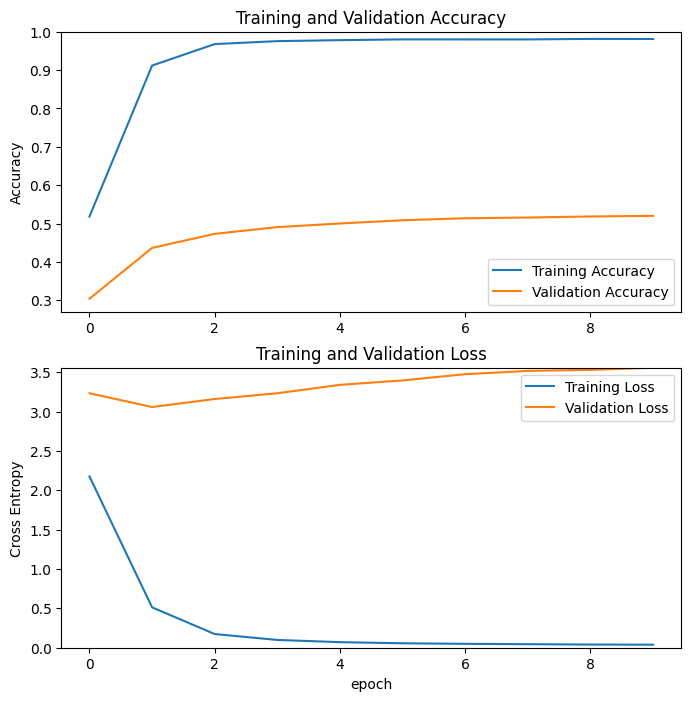

In [19]:
acc       = history.history['accuracy']
val_acc   = history.history['val_accuracy']
loss      = history.history['loss']
val_loss  = history.history['val_loss']

plt.figure(figsize=(8, 8))

plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()), 1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0, max(val_loss)])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')

plt.show()